In [1]:
%matplotlib inline

In [2]:
from SimEx.Analysis.DiffractionAnalysis import DiffractionAnalysis

import numpy, pyFAI
from matplotlib import pyplot as plt
import os, h5py

/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


initializing ocelot...



In [3]:
pattern_indices = 'all'
input_path="diffr.h5"

In [9]:
def azimuthalIntegration(pattern, parameters):

    # Extract parameters.
    beam = parameters['beam']
    geom = parameters['geom']

    # Photon energy and wavelength
    E0 = beam['photonEnergy']
    lmd = 1239.8 / E0

    # Pixel dimension
    apix = geom['pixelWidth']
    # Sample-detector distance
    Ddet = geom['detectorDist']
    # Number of pixels in each dimension
    Npix = geom['mask'].shape[0]

    # Find center.
    center = 0.5*(Npix-1)

    azimuthal_integrator = pyFAI.AzimuthalIntegrator(
            dist=Ddet,
            pixel1=apix,
            pixel2=apix,
            wavelength=lmd*1e-9)


    azimuthal_integrator.setFit2D(
            directDist=Ddet*1e3,
            centerX=center,
            centerY=center,
            tilt=0.0,
            tiltPlanRotation=0.0,
            pixelX=apix*1e6,
            pixelY=apix*1e6,
            )
    qs, intensities = azimuthal_integrator.integrate1d(
            pattern,
            min(Npix,1024),
            #unit="q_nm^-1",
            unit="2th_deg",
            )

    return qs, intensities

In [6]:
def diffractionParameters(path):
    """ Extract beam parameters and geometry from given file or directory.

    :param path: Path to file that holds the parameters to extract.
    :type path: str

    """

    # Check if old style.
    if os.path.isdir(path):
        h5_file = os.path.join(path, "diffr_out_0000001.h5")
    elif os.path.isfile(path):
        h5_file = path
    else:
        raise IOError("%s: no such file or directory." % (path))

    # Setup return dictionary.
    parameters_dict = {'beam':{}, 'geom':{}}

    # Open file.
    try:
        with h5py.File(h5_file, 'r') as h5:
            # Loop over entries in /params.
            for top_key in ['beam', 'geom']:
                # Loop over groups.
                for key, val in h5['params/%s' % (top_key)].items():
                    # Insert into return dictionary.
                    parameters_dict[top_key][key] = val.value
    except:
        pass
    # Return.
    return parameters_dict

In [21]:
analyzer = DiffractionAnalysis(input_path=input_path,
                               pattern_indices=pattern_indices,
                               poissonize=True
                               )

parameters = diffractionParameters(input_path)
nx, ny = parameters["geom"]["mask"].shape
mask = parameters["geom"]["mask"]
nx,ny = mask.shape
beamstop = 50
mask[nx//2-beamstop//2:nx//2+beamstop//2+1, ny//2-beamstop//2:ny//2+beamstop//2+1] = 0.0
analyzer.mask = mask

pattern = numpy.mean([p for p in analyzer.patterns_iterator],axis=0)
qs, intensities = azimuthalIntegration(pattern, diffractionParameters(input_path))

In [18]:
lk_88_phaseA_histogram = numpy.load('lk88_phaseA_angles_vs_weights.npz')
weights = lk_88_phaseA_histogram['weights']
angles = lk_88_phaseA_histogram['angles']

In [41]:
'c60_powder.mecury.tsv' in os.listdir('.')

True

In [42]:
mercury_powder = numpy.loadtxt('c60_powder.mecury.tsv')

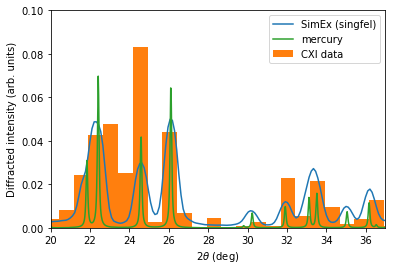

In [50]:
plt.plot(qs, intensities, label="SimEx (singfel)")
plt.hist(x=angles,weights=weights/weights.max()/100.,bins=35, label='CXI data')
plt.plot(mercury_powder[:,0], mercury_powder[:,1]/20000, label="mercury")
plt.xlabel(r"$2\theta$ (deg)")
plt.ylabel("Diffracted intensity (arb. units)")

plt.legend()

plt.xlim([20,37])
plt.ylim([0,0.1])

plt.savefig("CXIK8816_phaseAfcc_data_vs_simex_noRD.png", dpi=300)